#Identifying stop signs using transfer learning approaches.

**What is transfer learning?**

Transfer learning is a machine learning technique where knowledge gained from solving one task is applied to a different but related task.

Instead of training a model from scratch (which can be data- and compute-intensive), you "transfer" knowledge from a pre-trained model that has already learned features from a large dataset.

Installing the required libraries.

In [1]:
%%capture
!pip install tensorflow_datasets
!pip install --upgrade tensorflow
!pip install opendatasets
!pip install --upgrade skillsnetwork

In [2]:
#importing the required libraries
import numpy as np
import datetime
import os
import random, shutil
import glob
import skillsnetwork

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import opendatasets as od

2.20.0


The dataset is from skillsnetwork.

In [3]:
%%capture
#downloading data files
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/dataset/stop.zip",
                           overwrite=True)
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/dataset/not_stop.zip",
                           overwrite=True)
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/dataset/test_set_stop_not_stop.zip",
                           overwrite=True)

RuntimeError: Cannot run the event loop while another loop is running

#### Creating image directories

The image directories are rearranged as follows:

```python
signs/
└── train
    ├── stop
    └── not_stop
└── test
    ├── stop
    └── not_stop
```

We will have a train and a test directory, each contains images that have stop signs and those that don't.

In [ ]:
dataset_home = 'signs/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['stop/', 'not_stop/']
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        makedirs(newdir, exist_ok = True)

 Organize the image files into a training and testing dataset structure.

In [ ]:
for file in listdir("stop"):
    if file != '.DS_Store':
        shutil.copyfile(f"stop/{file}", f"signs/train/stop/{file}")

for file in listdir("not_stop"):
    if file != '.DS_Store':
        shutil.copyfile(f"not_stop/{file}", f"signs/train/not_stop/{file}")

test_path = "test_set_stop_not_stop/"
for file in listdir(test_path):
    if file.startswith("stop"):
        shutil.copyfile(test_path+file, f"signs/test/stop/{file}")
    elif file.startswith("not_stop"):
        shutil.copyfile(test_path+file, f"signs/test/not_stop/{file}")


Displaying raw images

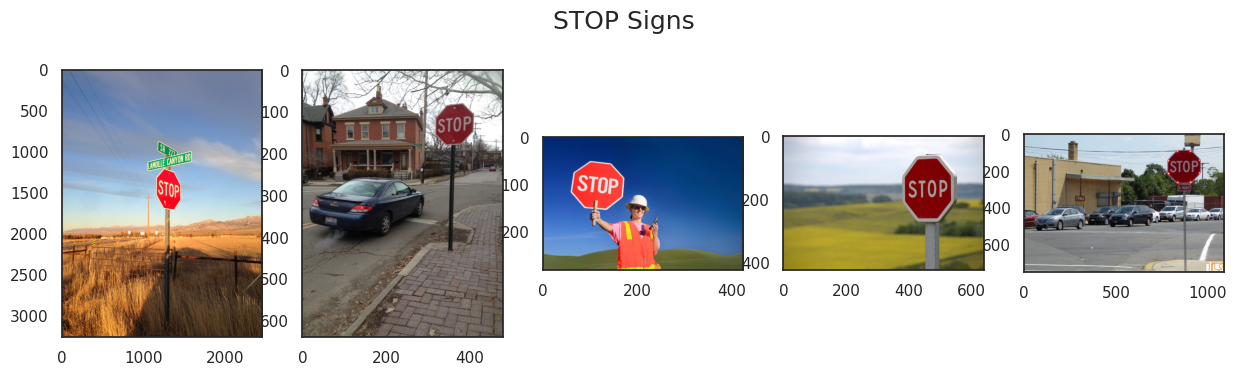

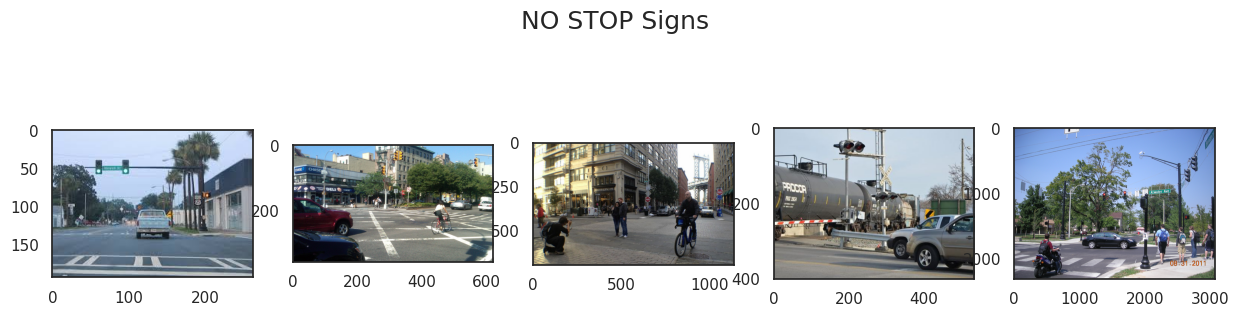

In [ ]:
#First 5 images of stop and not-stop images
train_stop = glob.glob('./signs/train/stop/*')
train_not_stop = glob.glob('./signs/train/not_stop/*')

fig1, ax1 = plt.subplots(1,5,figsize=(15,4))
fig1.suptitle("STOP Signs", fontsize=18)
l1 = [ax1[i].imshow(imread(train_stop[i])) for i in range(5)]

fig2, ax2 = plt.subplots(1,5,figsize=(15,4))
fig2.suptitle("NO STOP Signs", fontsize=18)
l2 = [ax2[i].imshow(imread(train_not_stop[i])) for i in range(5)]

Build image data generators to perform real-time augmentation.

Apply data augmentation to training data only.

20% of the images is split into validation dataset, and a batch size of 30 is selected.

In [ ]:
path = "signs/train/"
labels = ['stop', 'not_stop']
seed = 123
batch_size = 30
target_size = (160, 160)

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale=1./255.)

In [ ]:
#read images from folders and generate batches of preprocessed images.

train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=target_size,
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=target_size,
    subset = 'validation'
)

Found 158 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)

prob2class = lambda x: 'Stop' if x < 0.5 else 'Not Stop'


{'stop': 0, 'not_stop': 1}


Conver the test files into numpy arrays with pixel values scaled to 0-1

In [ ]:
from sklearn.utils import shuffle

test_files = glob.glob('signs/test/stop/*.jpeg') + glob.glob('signs/test/not_stop/*.jpeg')
test_files = shuffle(test_files)

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=target_size)) for img in test_files]
test_imgs = np.array(test_imgs).astype('int')

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

### Defining a helper function for building, compiling, and fitting CNNs


In [ ]:
def build_compile_fit(basemodel):

    # flatten the output of the base model
    x = Flatten()(basemodel.output)
    # add a fully connected layer
    x = Dense(1024, activation='relu')(x)
    # add dropout layer for regularization
    x = Dropout(0.2)(x)
    # add final layer for classification
    x = Dense(1, activation='sigmoid')(x)

    model = Model(basemodel.input, x)
    model.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001),
                                                       loss='binary_crossentropy',
                                                       metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor = 'loss',
                    patience = 5,
                    mode = 'min',
                    min_delta=0.01)]

    model.fit(train_generator,
              validation_data = val_generator,
              steps_per_epoch=5, # num of batches in one epoch
              epochs=10,
              callbacks=callbacks)

    return model

### Pre-trained Model 1: Inception-v3


**Inception-v3** is a successor to Inception-v1 with 24 million parameters and ran 48 layers deep.

Instead of focusing on increasing the depth of the network, InceptionNet focuses on increasing the width and depth of the model simultaneously to attain better accuracy, while keeping the computing resources constant.

It focuses on **parallel processing** and extraction of various feature maps concurrently using **Inception modules**, which are collections of convolutions with different filter sizes and pooling operations. The following is an illustration of the inception module in inception-v1 architecture:

<center>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L2/img/Inception_v1_module.png"></center>

Picture credits to [Wichai Puarungroj](https://www.researchgate.net/profile/Wichai-Puarungroj-2?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)

The inception architecture was refined in various ways, specifically for inception-v3, the following improvements are incorporated to achieve less expensive and still efficient network:

*   Factorization Into Smaller Convolutions
*   Factorization Into Asymmetric Convolutions
*   Auxiliary Classifier used as regularizer
*   Efficient Grid Size Reduction



The pre-trained part of the inception_v3 model utilizes the weights obtained from the 'imagenet' dataset training. Only the layers that we added are trained on the stop signs data.

In [ ]:
#import the pre-trained Inception-v3 architecture from keras applications for our transfer learning task
from keras.applications.inception_v3 import InceptionV3

# initialize the base model
basemodel = InceptionV3(input_shape=(160, 160,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
inception_v3 = build_compile_fit(basemodel)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.4778 - loss: 10.5388 - val_accuracy: 0.4872 - val_loss: 3.2397
Epoch 2/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6333 - loss: 2.6636

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 858ms/step - accuracy: 0.6333 - loss: 2.6636 - val_accuracy: 0.8462 - val_loss: 0.3226
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.8247 - loss: 0.5554 - val_accuracy: 0.4872 - val_loss: 2.8817
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5333 - loss: 2.8145 - val_accuracy: 0.7436 - val_loss: 0.8958
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.6983 - loss: 1.1690 - val_accuracy: 0.5128 - val_loss: 1.8145
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 884ms/step - accuracy: 0.5000 - loss: 1.3827 - val_accuracy: 0.7692 - val_loss: 1.0322
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5795 - loss: 1.7664 - val_accuracy: 0.8462 - val_loss: 0.3878
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 806ms/step - accuracy: 0.7667 - loss: 0.7634 - val_accuracy: 0.8462 - val_loss: 0.3834


Display test images with the class labels as predicted by the inception v3 model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


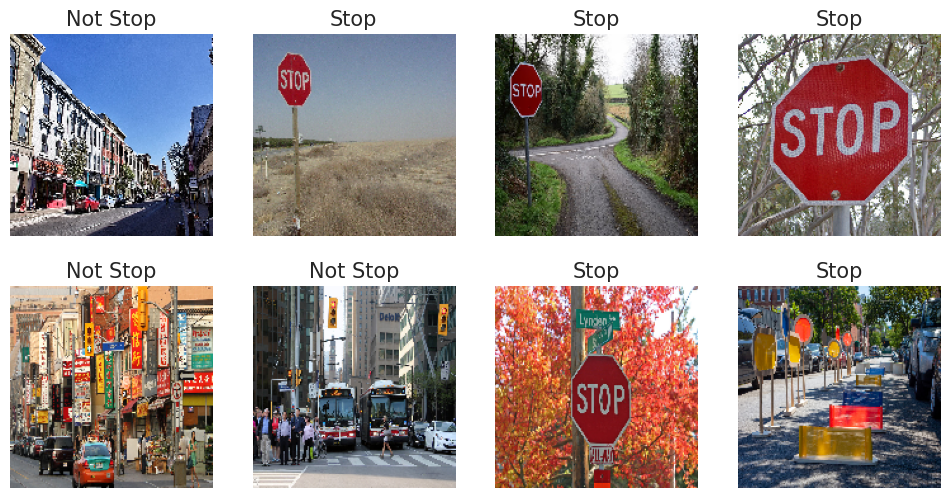

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(inception_v3.predict(test_imgs_scaled[i].reshape(1, 160, 160,3)))

    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")

### Pre-trained Model 2: MobileNet


**MobileNets** are very efficient and small deep learning architectures specially designed for mobile devices.

It makes use of a new kind of convolution layer, known as **Depthwise Separable convolution**. The main difference between a 2D convolution and a Depthwise convolution is that, the former is performed over multiple input channels by doing weighted sum of the input pixels with the filter, whereas the latter is performed separately over each channel.

For example, if the input image has three channels then the output of depthwise separable convolution will also have three channels. The next step is **Pointwise convolution**, which is similar to a regular convolution with a $1\times1$ filter. By doing so, we can again merge the three channels from depthwise separable convolution into one to creare new features.


In [ ]:
#import the pre-trained mobilenet architecture
from keras.applications.mobilenet import MobileNet

# initialize the base model
basemodel = MobileNet(input_shape=(160, 160,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
mobile_net = build_compile_fit(basemodel)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6115 - loss: 5.9291 - val_accuracy: 0.8205 - val_loss: 1.0765
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 941ms/step - accuracy: 0.7000 - loss: 2.0004 - val_accuracy: 0.4872 - val_loss: 5.9746
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6134 - loss: 2.6213 - val_accuracy: 0.7949 - val_loss: 0.4106
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - accuracy: 1.0000 - loss: 0.0576 - val_accuracy: 0.8718 - val_loss: 0.2094
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8873 - loss: 0.3364 - val_accuracy: 0.8205 - val_loss: 0.3016
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - accuracy: 0.8333 - loss: 0.4854 - val_accuracy: 0.9231 - val_loss: 0.2395
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8803 - loss: 0.4564 - val_accuracy: 0.9231 - val_loss: 0.1877
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - accuracy: 0.9667 - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


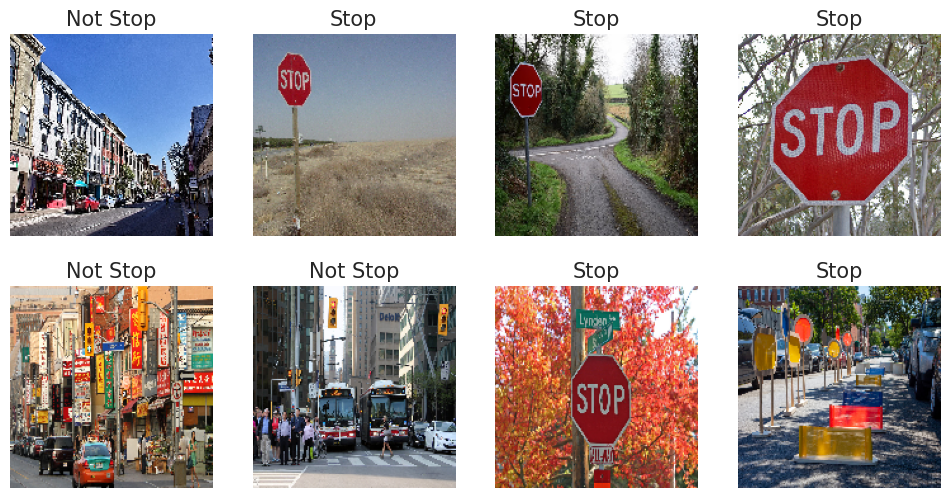

In [ ]:
#display the test images along with the their class labels predicted by the fitted mobile_net:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(mobile_net.predict(test_imgs_scaled[i].reshape(1, 160, 160,3)))

    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")

### Pre-trained Model 3: ResNet-50


**ResNet** features special skip connections which add the output from an earlier layer directly to a later layer and a heavy use of batch normalization. It allows us to design deep CNNs without compromising the model’s convergence and accuracy. The basic building blocks for ResNets is the convolution and identity blocks.

Essentially, ResNet uses the network layers to fit a residual mapping $F(x) + x$, instead of trying to learn the desired underlying mapping $H(x)$ directly with stacked layers.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L2/img/resnet.png" width="30%"></center>

The formulation of $F(x) + x$ can be realized by the feedforward neural networks with **shortcut connections**. Shortcut connections add the output from previous layer directly to the output of the current layer, which can be seen as **identity mapping**.

By doing so, the network overcomes the vanishing gradient problem because now the gradient signals could travel back to early layers through this shortcut.


In [ ]:
#import the ResNet-50 architecture from the keras application
from keras.applications import ResNet50

# initialize the base model
basemodel = ResNet50(input_shape=(160, 160,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
resnet_50 = build_compile_fit(basemodel)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.5342 - loss: 1.2721 - val_accuracy: 0.4872 - val_loss: 0.9865
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4667 - loss: 1.1174 - val_accuracy: 0.5128 - val_loss: 1.4142
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.4291 - loss: 1.3968 - val_accuracy: 0.4872 - val_loss: 0.7665
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5667 - loss: 0.7149 - val_accuracy: 0.4872 - val_loss: 0.7034
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.5087 - loss: 0.8098 - val_accuracy: 0.5128 - val_loss: 0.7272
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5333 - loss: 0.7485 - val_accuracy: 0.4872 - val_loss: 0.7289
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.5389 - loss: 0.7244 - val_accuracy: 0.4872 - val_loss: 1.5417
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.4333 - loss: 1.7574 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


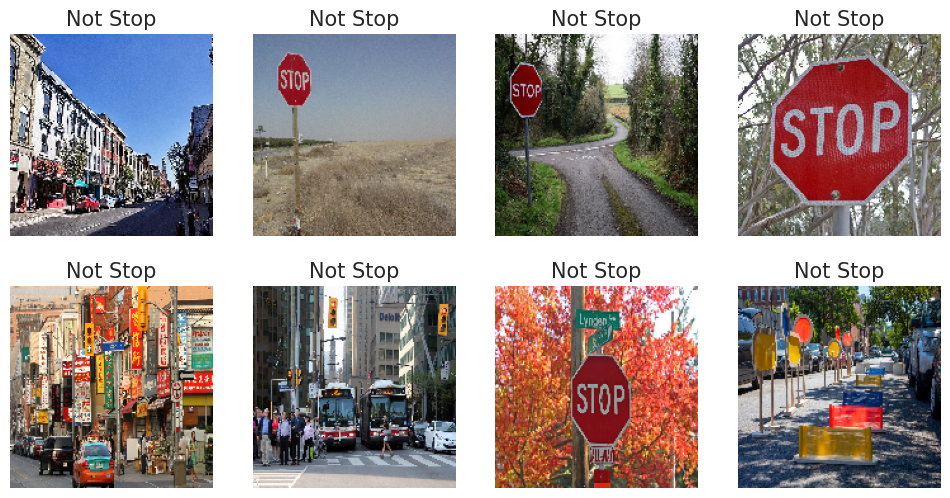

In [ ]:
#display the test images along with the their class labels predicted by the fitted mobile_net:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(resnet_50.predict(test_imgs_scaled[i].reshape(1, 160, 160,3)))

    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")